### Problem Statement 

To build a Convolutional Neural Network based model which can accurately detect melanoma . 

<b>Melanoma</b>

About Melanoma , it is a dangerous form of skin cancer that develops from melanocytes(cells that produce melanin) , the pigment that gives skin its colour . It typically occurs on the skin but can also develop in the mouth , intestines or eye . 

It can be deadly if not detected early . It accounts for 75% of skin cancer deaths . 

A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis .

It can analyse skin images to identify patterns associated with melanoma , aiding in 
early detection and potentially improving diagnosis accuracy .

<b>Motivation</b> : To create a multiclass classification model using a custom convolutional neural network in tensorflow .

#### Importing Skin Cancer Data 

<b>Data Summary</b>

The dataset consists of images of malignant and benign oncological diseases , which were formed from the Internation Skin Imaging Collaboration (ISIC) . 

All images were sorted according to the classification taken with ISIC , and all subsets were divided into the same number of images , with the exception of melanomas and moles , whose images are slightly dominant .

The dataset contains of 9 sub-directories for both training and testing dataset , which contains the images of 9 skin cancer types respectively .

The dataset consists of the following diseases : <br>
1. Actinic keratosis
2. Basal cell carcinoma
3. Dermatofibroma
4. Melanoma
5. Nevus
6. Pigmented benign keratosis
7. Seborrheic keratosis
8. Squamous cell carcinoma
9. Vascular lesion

In [ ]:
# importing libraries 

import pathlib 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import os 

from glob import glob

import PIL 
import Augmentor

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import load_img
# from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import LayerNormalization , BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
# from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot encoding

ModuleNotFoundError: No module named 'tensorflow.keras.layers.experimental'

In [2]:
# Reading the data 

root_path = '/Users/ritwik/Desktop/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration'

data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

Counting the number of images in Train and Test directory 

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg'))) # using the glob to retrieve files/pathnames matching a specified pattern
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))

print(image_count_train)
print(image_count_test)

2239
118


Load using keras.preprocessing

Loading the images using the 'image_dataset_from_directory' utility offered by keras . 

What does it do ? <br>
It creates an image dataset from a dictionary where keys represent class labels and values are lists of image file paths , making it convinient for training image classification models .

Visualing one instance of each class present in the dataset , with the help of the 'image_dataset_from_directory'.

In [4]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train , 
                                                                    batch_size=32 , 
                                                                    image_size=(180,180),
                                                                    label_mode='categorical',
                                                                    seed=123)


Found 2239 files belonging to 9 classes.


In [5]:
class_names = image_dataset.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

Creating a dictionary to store the path of the image as per the class 

In [6]:
files_path_dict = {}

# list(map(lambda x:str(data_dir_train)+'/'+'actinic keratosis'+'/'+x, os.listdir(str(data_dir_train)+'/'+'actinic keratosis')))

for names in class_names:
    # files_path_dict[names] = list(map(lambda x:str(data_dir_train)+'/'+names+'/'+x , os.listdir(str(data_dir_train)+'/'+names)))
    files_path_dict[names] = list(map(lambda x : str(data_dir_train)+'/'+names+'/'+x, os.listdir(str(data_dir_train)+'/'+names)))
# files_path_dict

Visualising the first image of every sub-directory

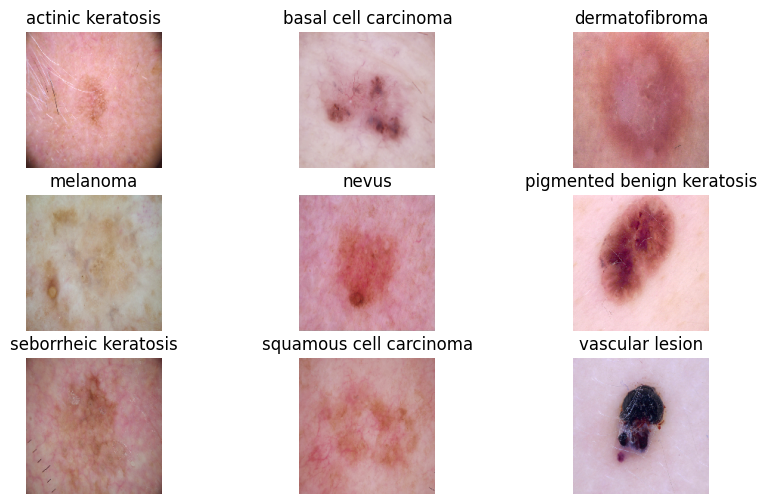

In [7]:
plt.figure(figsize=[10,6])
index = 0
for names in class_names:
    path_list = files_path_dict[names][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0], target_size=(180,180)))
    plt.title(names)
    plt.axis("off")

Visualising distribution of classes in the training dataset 

In [8]:
def class_distribution_count(directory):

    # counting the number of images in each classes 
    count = []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path,name))]))
    
    # name of the classes
    sub_directory = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

    # return dataframe with image count and class 
    return pd.DataFrame(list(zip(sub_directory, count)), columns=['Class','No. of Image'])

df = class_distribution_count(data_dir_train)
df.sort_values(by='No. of Image', ascending=False)

,Class,No. of Image
1,pigmented benign keratosis,462
0,melanoma,438
3,basal cell carcinoma,376
2,nevus,357
5,squamous cell carcinoma,181
6,vascular lesion,139
4,actinic keratosis,114
8,dermatofibroma,95
7,seborrheic keratosis,77


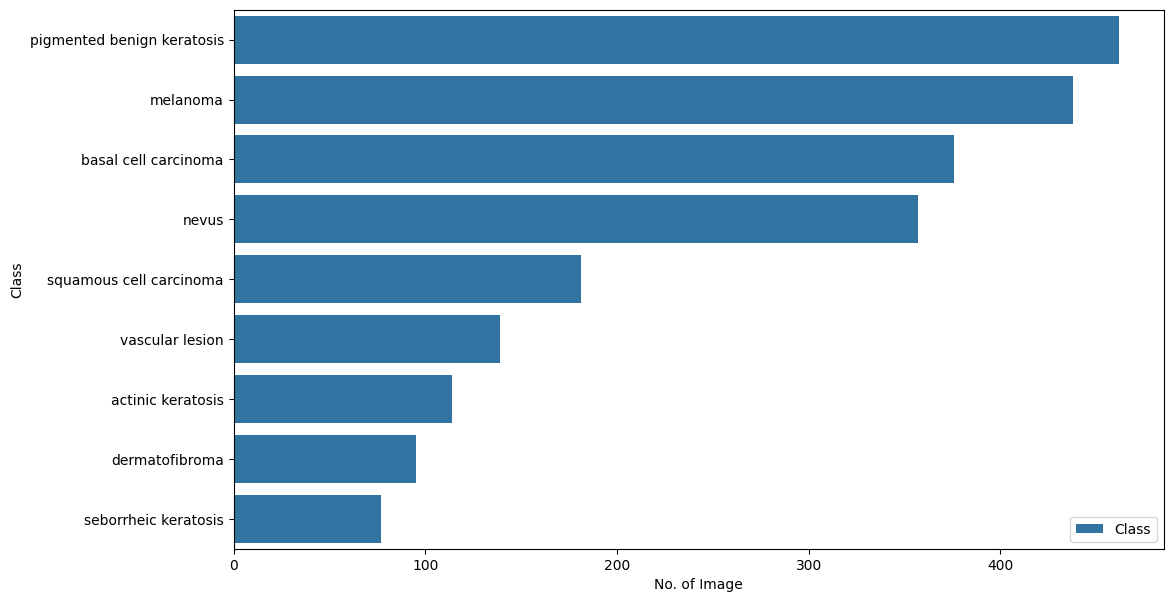

In [9]:
plt.figure(figsize=[12,7])

sns.barplot(data=df.sort_values(by='No. of Image', ascending=False) , x='No. of Image', y='Class', label='Class'); 

Observation 

There is a class imbalance . 

<b>How can class imbalance lead to biased models that favour the majority class ?</b>

- It can result in poor performance on the minority class , which is often the class of interest in medical image analysis tasks like melanoma detection .

- Rectifying class imbalance ensures that the model learns from a balanced representation of all classes , leading to more accurate and reliable predictions . 

Which class has the least and the most number of samples ? 
- Least = "seborrheic keratosis" 
- Most = "pigmented benign keratosis"

To deal with class imbalance , we will use a Python package called <b>Augmentor</b>.

Augmentor can address class imbalance by over-sampling the minority class . It applies a variety of image augmentation techniques (eg. rotation , flips , zooms) to the minority class images , creating synthetically augmented data to increase its representation in the training set .

To use Augmentor , the general procedure followed is :

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set .

2. Define a number of operations to perform on this data set using your Pipeline object . 

3. Execute these operations by calling the Pipeline's sample() method .

In [10]:
path_to_training_dataset = "/Users/ritwik/Desktop/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

for names in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + names)
    p.rotate(probability=0.7 , max_left_rotation=10 , max_right_rotation=10)
    p.sample(500) # Adding 500 samples per class to make sure that none of the classes are sparse 

Initialised with 114 image(s) found.
Output directory set to /Users/ritwik/Desktop/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3087A1FF0>: 100%|██████████| 500/500 [00:02<00:00, 216.85 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /Users/ritwik/Desktop/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x30F8530D0>: 100%|██████████| 500/500 [00:02<00:00, 225.96 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /Users/ritwik/Desktop/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x308763040>: 100%|██████████| 500/500 [00:02<00:00, 209.43 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /Users/ritwik/Desktop/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x30F89F9D0>: 100%|██████████| 500/500 [00:09<00:00, 50.24 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to /Users/ritwik/Desktop/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2117x1988 at 0x308760D30>: 100%|██████████| 500/500 [00:09<00:00, 50.46 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to /Users/ritwik/Desktop/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3087C0970>: 100%|██████████| 500/500 [00:02<00:00, 216.22 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /Users/ritwik/Desktop/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x10398CE80>: 100%|██████████| 500/500 [00:05<00:00, 99.26 Samples/s]                   


Initialised with 181 image(s) found.
Output directory set to /Users/ritwik/Desktop/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x308763580>: 100%|██████████| 500/500 [00:02<00:00, 213.23 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /Users/ritwik/Desktop/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x10398EB60>: 100%|██████████| 500/500 [00:02<00:00, 210.36 Samples/s]                  


After running the Augmentor module , the original minority class images are augmented , resulting in a significantly increased number of images for that class . 

Thus , this dataset can now be used to train a CNN , ensuring that the model has sufficient data to learn from the minority class and improve its performance on imbalanced datasets .

Checking the total count of augmented images .

In [11]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Checking the distribution of augmented data after adding new images to the original training data 

In [14]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

dataframe_dict_new = dict(zip(path_list , lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path','Label'])

new_df = df2 

display(new_df)

,Path,Label
0,/Users/ritwik/Desktop/Melanoma Detection Assig...,melanoma
1,/Users/ritwik/Desktop/Melanoma Detection Assig...,melanoma
2,/Users/ritwik/Desktop/Melanoma Detection Assig...,melanoma
3,/Users/ritwik/Desktop/Melanoma Detection Assig...,melanoma
4,/Users/ritwik/Desktop/Melanoma Detection Assig...,melanoma
...,...,...
4495,/Users/ritwik/Desktop/Melanoma Detection Assig...,dermatofibroma
4496,/Users/ritwik/Desktop/Melanoma Detection Assig...,dermatofibroma
4497,/Users/ritwik/Desktop/Melanoma Detection Assig...,dermatofibroma
4498,/Users/ritwik/Desktop/Melanoma Detection Assig...,dermatofibroma


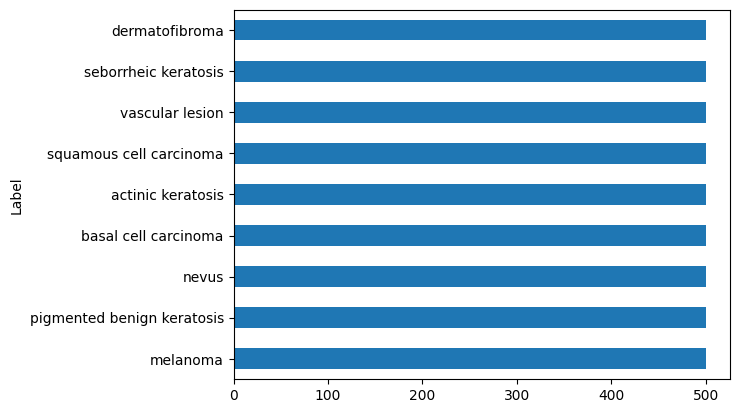

In [17]:
new_df['Label'].value_counts().plot(kind='barh'); 

All the 9 sub-directories have added 500 images to all the classes to maintain class balance .

In [18]:
batch_size = 32 
img_height = 180 
img_width = 180

# Use 80% of the images for training , and 20% for validation 

# Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train , validation_split=0.2 , subset='training' , seed=123 , 
    image_size=(img_height,img_width) , batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [20]:
# Note use seed = 123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory note 

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test , validation_split=0.2 , subset='training' , seed=123 , 
    image_size=(img_height,img_width) , batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 95 files for training.


In [22]:
class_names = train_ds.class_names 
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Using tf.data.experimental.AUTOTUNE . 

What is it used for ? 
- It is used for automatically optimising data pipeline performance in Tensorflow . It tunes factors like the number of elements to prefetch for training , aiming to achieve the best speed for your specific hardware .

In [23]:
autotune = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=autotune)
val_ds = val_ds.cache().prefetch(buffer_size=autotune)

### Creating the model 